In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load datasets
cpt_df = pd.read_csv("cptcleaned.csv")
jhb_df = pd.read_csv("JHBcleaned.csv")


In [ ]:
#Adding a province column for each dataset
cpt_df["Province"] = "Western Cape"
jhb_df["Province"] = "Gauteng"

In [4]:
# Rename Ambiance columns to avoid conflicts
cpt_df = cpt_df.rename(columns={
    "Ambiance_Label": "Ambiance_Label_WC",
    "Ambiance_Category": "Ambiance_Category_WC",
    "Image_Url2": "Image Url_2"
})

jhb_df = jhb_df.rename(columns={
    "Ambiance_Label": "Ambiance_Label_GP",
    "Ambiance_Category": "Ambiance_Category_GP"
})

# Find all unique columns across both datasets
all_columns = set(cpt_df.columns).union(set(jhb_df.columns))

# Ensure both DataFrames have the same columns by adding missing ones
for col in all_columns:
    if col not in cpt_df:
        cpt_df[col] = 0  # Fill missing columns with 0
    if col not in jhb_df:
        jhb_df[col] = 0  # Fill missing columns with 0


In [5]:
# Merge both datasets
merged_df = pd.concat([cpt_df, jhb_df], ignore_index=True)
merged_df.to_csv("merged_restaurants.csv")
print("CSV file saved successfully!")

CSV file saved successfully!


In [6]:
merged_df = merged_df.drop('Unnamed: 0', axis=1)
print(merged_df.head())

                       Restaurant Name  \
0                     Ground Art Caffe   
1                         Jason Bakery   
2  Rosetta Roastery Cafe (Bree Street)   
3                   Heaven Coffee Shop   
4                           The Ladder   

                                       Opening Hours  \
0  Monday 07:00-15:00; Tuesday 07:00-15:00; Wedne...   
1  Tuesday 07:00-15:00; Wednesday 07:00-15:00; Th...   
2  Monday 07:00-16:00; Tuesday 07:00-16:00; Wedne...   
3  Tuesday 07:00-17:00; Wednesday 07:00-17:00; Th...   
4  Tuesday 07:00-16:00; Wednesday 07:00-16:00; Th...   

                                             Address   Contact Number  \
0       160 Strand St, De Waterkant, Cape Town, 8001  +27 21 418 1331   
1           83 Main Rd, Green Point, Cape Town, 8005  +27 21 433 0538   
2                  101 Bree St, CBD, Cape Town, 8001  +27 21 447 4099   
3  38 Burg St, Cape Town City Centre, Cape Town, ...  +27 72 884 2057   
4  136 Bree St, Cape Town City Centre, Cape T

In [7]:
print(merged_df.isnull().sum())

Restaurant Name         0
Opening Hours           0
Address                 0
Contact Number          0
Ambiance                0
                       ..
modern south african    0
Suburb_Melville         0
modern european         0
Suburb_Jeppestown       0
Suburb_Muldersdrift     0
Length: 137, dtype: int64


In [8]:
merged_df.to_csv("merged_restaurants.csv")
print("CSV file saved successfully!")

CSV file saved successfully!


In [9]:
for col in merged_df.columns:
    if merged_df[col].dtype == 'bool': 
        merged_df[col] = merged_df[col].astype(int)

print(merged_df.columns)

Index(['Restaurant Name', 'Opening Hours', 'Address', 'Contact Number',
       'Ambiance', 'Reservations', 'Image Url', 'Image Url_2', 'Rating_Value',
       'Review_Count',
       ...
       'Suburb_Kyalami', 'modern bistro', 'chinese fusion', 'Suburb_Bryanston',
       'middle eastern fusion', 'modern south african', 'Suburb_Melville',
       'modern european', 'Suburb_Jeppestown', 'Suburb_Muldersdrift'],
      dtype='object', length=137)


In [10]:
print(merged_df["Ambiance_Label_GP"])

0                                      0
1                                      0
2                                      0
3                                      0
4                                      0
                     ...                
158        Elegant & Contemporary Dining
159                 Modern & Cozy Dining
160                 Modern & Cozy Dining
161    Traditional & Inviting Atmosphere
162                 Modern & Cozy Dining
Name: Ambiance_Label_GP, Length: 163, dtype: object


In [13]:
# Get all suburb columns
suburb_cols = [col for col in merged_df.columns if col.startswith('Suburb_')]

# Create a copy of the DataFrame to avoid fragmentation
df = merged_df.copy()

# Create the Suburb column using numpy where conditions
df['Suburb'] = ''
for col in suburb_cols:
    suburb_name = col.replace('Suburb_', '')
    # Where this suburb column is 1, set the suburb name
    df.loc[merged_df[col] == 1, 'Suburb'] = suburb_name

print(df['Suburb'])

0               De Waterkant
1                Green Point
2      Cape Town City Centre
3      Cape Town City Centre
4      Cape Town City Centre
               ...          
158                  Melrose
159                  Sandown
160                 Rosebank
161                   Linden
162           Craighall Park
Name: Suburb, Length: 163, dtype: object


In [14]:
print(df.head(10))

                       Restaurant Name  \
0                     Ground Art Caffe   
1                         Jason Bakery   
2  Rosetta Roastery Cafe (Bree Street)   
3                   Heaven Coffee Shop   
4                           The Ladder   
5                         Cafe Chiffon   
6                         Naked Coffee   
7                          Halō Coffee   
8                   Belly Of The Beast   
9                       Fyn Restaurant   

                                       Opening Hours  \
0  Monday 07:00-15:00; Tuesday 07:00-15:00; Wedne...   
1  Tuesday 07:00-15:00; Wednesday 07:00-15:00; Th...   
2  Monday 07:00-16:00; Tuesday 07:00-16:00; Wedne...   
3  Tuesday 07:00-17:00; Wednesday 07:00-17:00; Th...   
4  Tuesday 07:00-16:00; Wednesday 07:00-16:00; Th...   
5  Tuesday 07:30-17:00; Wednesday 07:30-17:00; Th...   
6  Tuesday 07:00-17:00; Wednesday 07:00-17:00; Th...   
7  Monday 06:30-16:00; Tuesday 06:30-16:00; Wedne...   
8  Friday 12:00-15:00, 06:30-22:0

In [19]:
# Create a new binary column 'High_Rated'
df['High_Rated'] = (df['Rating_Value'] > 4.4).astype(int)

# View the first few rows to confirm it worked
print(df[['Rating_Value', 'High_Rated']].head())

   Rating_Value  High_Rated
0           4.8           1
1           4.5           1
2           4.7           1
3           4.7           1
4           4.6           1


Percentage of high-rated restaurants: 82.21%


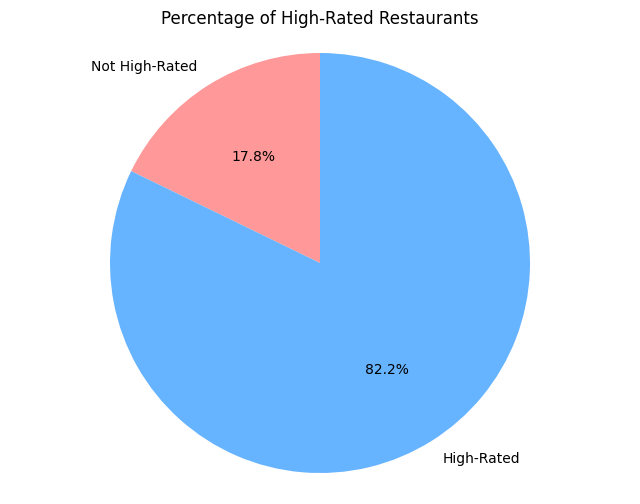

In [20]:
# Calculate the percentage of high-rated restaurants
high_rated_percentage = df['High_Rated'].mean() * 100
print(f"Percentage of high-rated restaurants: {high_rated_percentage:.2f}%")

# 1. Create a pie chart for high-rated vs. not high-rated
plt.figure(figsize=(8, 6))
labels = ['Not High-Rated', 'High-Rated']
sizes = [(100 - high_rated_percentage), high_rated_percentage]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.axis('equal')
plt.title('Percentage of High-Rated Restaurants')
plt.show()


Province
Gauteng         65.277778
Western Cape    95.604396
Name: High_Rated, dtype: float64


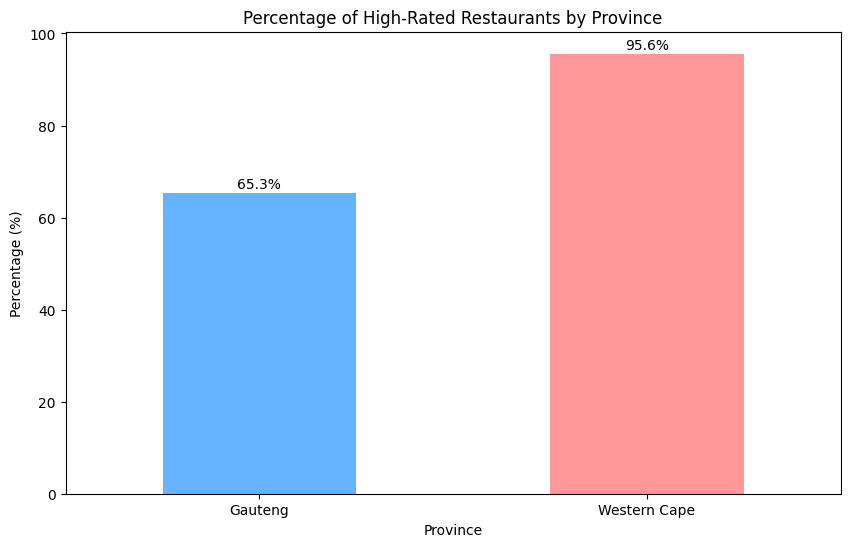

In [21]:
# 2. Compare high-rated restaurants by province
# Assuming your dataset has a 'Province' column with 'Western Cape' and 'Gauteng' values
province_high_rated = df.groupby('Province')['High_Rated'].mean() * 100
print(province_high_rated)

# Bar chart comparing provinces
plt.figure(figsize=(10, 6))
province_high_rated.plot(kind='bar', color=['#66b3ff', '#ff9999'])
plt.title('Percentage of High-Rated Restaurants by Province')
plt.ylabel('Percentage (%)')
plt.xlabel('Province')
plt.xticks(rotation=0)
for i, v in enumerate(province_high_rated):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.show()

In [23]:
# Calculate average price as the mean of min and max prices
df['Avg_Price'] = (df['Avg_Min_Price'] + df['Avg_Max_Price']) / 2
print(df['Avg_Price'])

0      125.0
1      175.0
2       75.0
3       75.0
4      125.0
       ...  
158    200.0
159    200.0
160    750.0
161    750.0
162    750.0
Name: Avg_Price, Length: 163, dtype: float64


In [24]:
# Calculate the 25th and 75th percentiles
q1 = df['Avg_Price'].quantile(0.25)
q3 = df['Avg_Price'].quantile(0.75)

# Create a new feature 'Price_Category'
df['Price_Category'] = pd.cut(df['Avg_Price'],
                               bins=[-float('inf'), q1, q3, float('inf')],
                               labels=['Non-Expensive', 'Medium Expensive', 'Expensive'])
print(df['Price_Category'])

0         Non-Expensive
1         Non-Expensive
2         Non-Expensive
3         Non-Expensive
4         Non-Expensive
             ...       
158    Medium Expensive
159    Medium Expensive
160           Expensive
161           Expensive
162           Expensive
Name: Price_Category, Length: 163, dtype: category
Categories (3, object): ['Non-Expensive' < 'Medium Expensive' < 'Expensive']


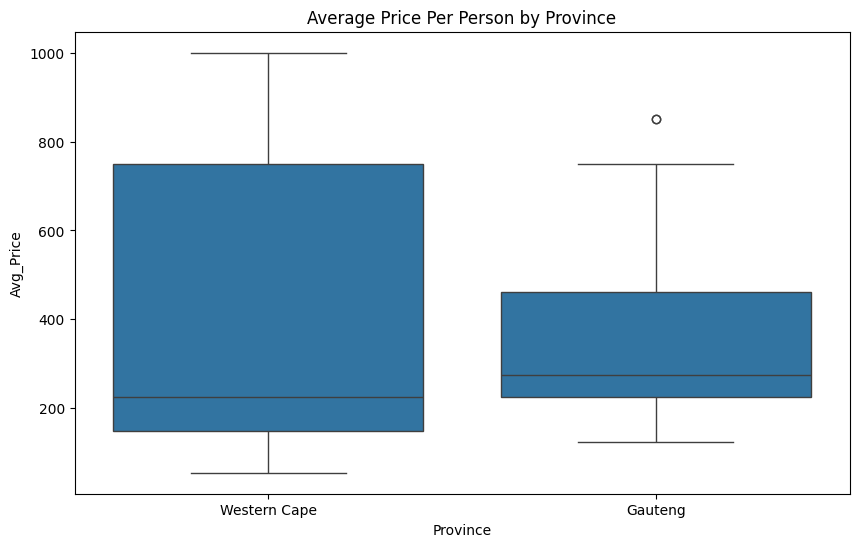

In [25]:
# Box plot of Avg_Price by Province
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Province', y='Avg_Price')
plt.title('Average Price Per Person by Province')
plt.xlabel('Province')
plt.ylabel('Avg_Price')
plt.show()


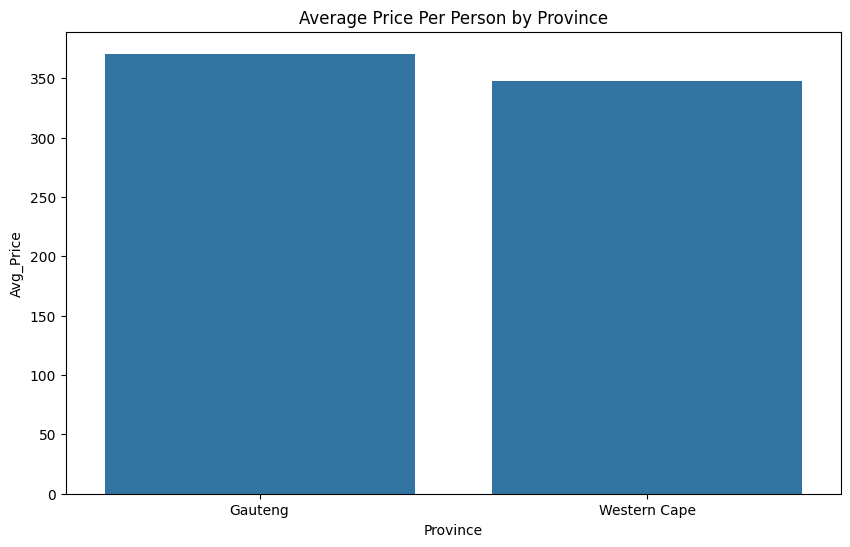

In [28]:
# Bar plot of mean Avg_Price by Province
mean_prices = df.groupby('Province')['Avg_Price'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=mean_prices, x='Province', y='Avg_Price')
plt.title('Average Price Per Person by Province')
plt.xlabel('Province')
plt.ylabel('Avg_Price')
plt.show()

C:\Users\Game\AppData\Local\Temp\ipykernel_15684\757912088.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_counts = df.groupby(['Province', 'Price_Category']).size().unstack().fillna(0)


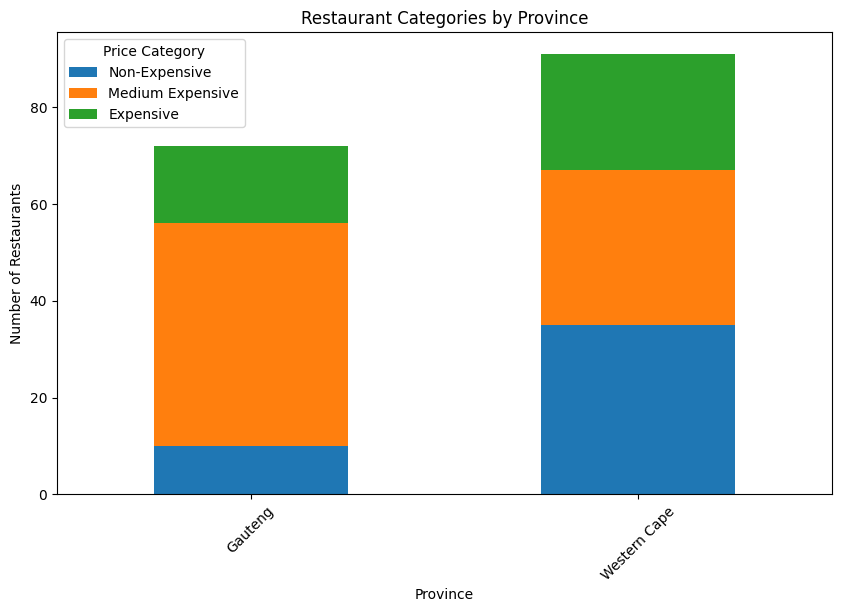

In [29]:
# Count restaurants in each price category by Province
category_counts = df.groupby(['Province', 'Price_Category']).size().unstack().fillna(0)

# Stacked bar plot
category_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Restaurant Categories by Province')
plt.xlabel('Province')
plt.ylabel('Number of Restaurants')
plt.xticks(rotation=45)
plt.legend(title='Price Category')
plt.show()


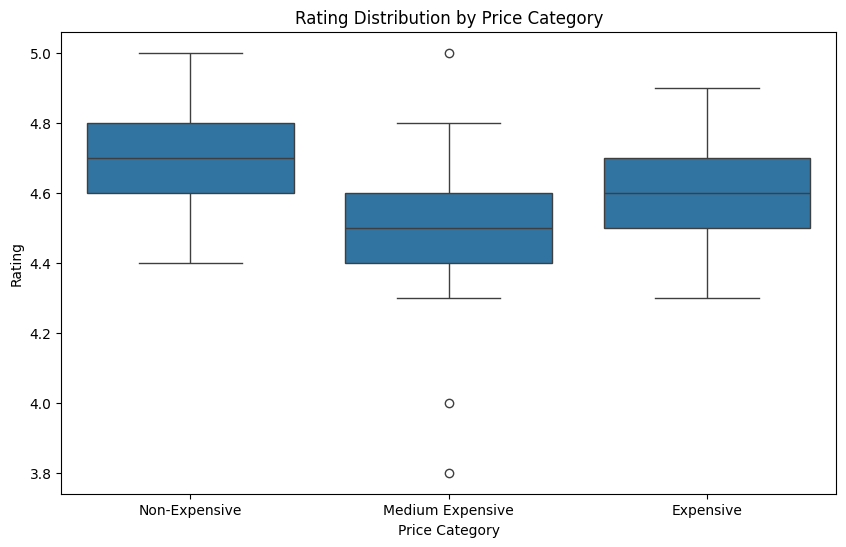

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Price_Category', y='Rating_Value')
plt.title('Rating Distribution by Price Category')
plt.xlabel('Price Category')
plt.ylabel('Rating')
plt.show()

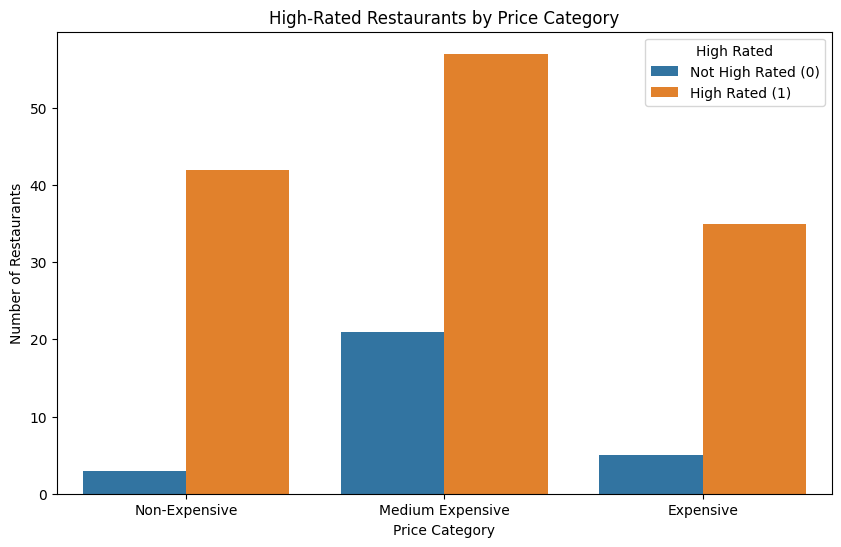

In [33]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Price_Category', hue='High_Rated')
plt.title('High-Rated Restaurants by Price Category')
plt.xlabel('Price Category')
plt.ylabel('Number of Restaurants')
plt.legend(title='High Rated', labels=['Not High Rated (0)', 'High Rated (1)'])
plt.show()

C:\Users\Game\AppData\Local\Temp\ipykernel_15684\1389943075.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_category = df.groupby('Price_Category')['Avg_Price'].mean().reset_index()


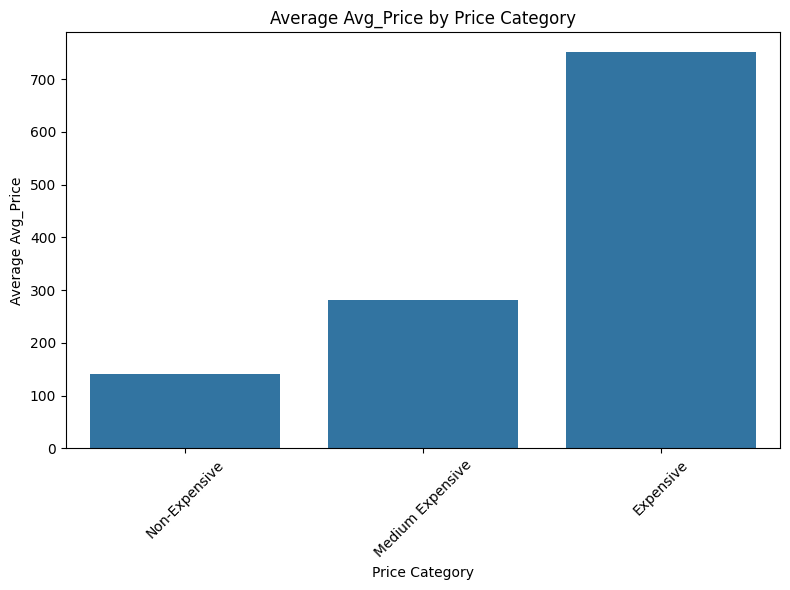

In [35]:
# Calculate the average Avg_Price for each Price_Category
avg_price_by_category = df.groupby('Price_Category')['Avg_Price'].mean().reset_index()

# Create a bar chart using seaborn
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.barplot(x='Price_Category', y='Avg_Price', data=avg_price_by_category)

plt.xlabel('Price Category')
plt.ylabel('Average Avg_Price')
plt.title('Average Avg_Price by Price Category')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [36]:
print(df['Ambiance'].isnull().sum())

0


In [38]:
# Define stopwords (same as before)
custom_stopwords = [
    'a', 'an', 'the', 'and', 'but', 'or', 'for', 'nor', 'on', 'at', 'to', 'by', 
    'from', 'this', 'that', 'in', 'of', 'is', 'are', 'was', 'were', 'be', 'been',
    'being', 'have', 'has', 'had', 'do', 'does', 'did', 'can', 'could', 'will',
    'would', 'should', 'shall', 'may', 'might', 'must', 'with', 'within', 'its',
    'it', 'restaurant', 'offers', 'featuring', 'known', 'which', 'where',
    'serving', 'meals', 'great', 'making', 'high quality', 'offering', 
    'their', 'set', 'menu', 'point', 'delicious', 'focus', 'lovers', 'cape', 'cape town', 
    'bree', 'yet', 'bree street', 'high', 'quality', 'street', 'town', 'a', 'an', 'the', 'and', 'but', 'or', 'for', 'nor', 'on', 'at', 'to', 'by', 
    'from', 'this', 'that', 'in', 'of', 'is', 'are', 'was', 'were', 'be', 'been',
    'being', 'have', 'has', 'had', 'do', 'does', 'did', 'can', 'could', 'will',
    'would', 'should', 'shall', 'may', 'might', 'must', 'with', 'within', 'its',
    'it', 'restaurant', 'offers', 'featuring', 'known', 'has', 'which', 'where'
]

# Preprocessing the ambiance text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  
    words = text.split()
    words = [word for word in words if word not in custom_stopwords]
    return ' '.join(words)

# Applying preprocessing and vectorization
count_vectorizer = CountVectorizer(
    stop_words=custom_stopwords, 
    max_features=100,  # You can adjust this value
    ngram_range=(1, 2)  # Unigrams and bigrams
)
count_matrix = count_vectorizer.fit_transform(df['Ambiance'].apply(preprocess_text))

# LDA Topic Modeling \, 6 topics
lda = LatentDirichletAllocation(n_components=6, random_state=42)
lda.fit(count_matrix)

# Extract Top Words for Each Topic
feature_names = count_vectorizer.get_feature_names_out()
topics = {}
for topic_idx, topic in enumerate(lda.components_):
    top_keywords = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
    topics[f'Topic {topic_idx+1}'] = top_keywords

# Display topics and keywords
for topic, keywords in topics.items():
    print(f"{topic}: {', '.join(keywords)}")


Topic 1: vibrant, casual, lively, fresh, atmosphere, eatery, relaxed, food, dining, contemporary
Topic 2: spot, popular, atmosphere, brunch, popular spot, atmosphere popular, lunch, brunch lunch, spot brunch, sushi
Topic 3: dining, experience, dining experience, dishes, italian, intimate, ambiance, sophisticated, cuisine, elegant
Topic 4: modern, ambiance, sophisticated, stylish, contemporary, upscale, chic, sushi, relaxed, aesthetic
Topic 5: coffee, café, atmosphere, inviting, inviting atmosphere, perfect, whether youre, youre, spot, whether
Topic 6: vibe, casual, perfect, relaxed, welcoming, cozy, warm, spot, laidback, charming


In [39]:
# Assigning topic distributions
topic_distributions = lda.transform(count_matrix)

# Assigning dominant topic to each restaurant
df['Ambiance_Category'] = topic_distributions.argmax(axis=1)  

# Mapping topic numbers to theme labels
ambiance_labels = {
    0: "Trendy & Vibrant Casual Dining",
    1: "Popular Brunch & Café Spot",
    2: "Elegant & Contemporary Dining",
    3: "Chic & Elegant Modern Dining",
    4: "Traditional & Inviting Atmosphere",
    5: "Modern & Cozy Dining",
}

# Assigning the corresponding theme label to each restaurant
df['Ambiance_Label'] = df['Ambiance_Category'].map(ambiance_labels)

print(df[['Restaurant Name', 'Ambiance_Label']])

                         Restaurant Name                     Ambiance_Label
0                       Ground Art Caffe               Modern & Cozy Dining
1                           Jason Bakery  Traditional & Inviting Atmosphere
2    Rosetta Roastery Cafe (Bree Street)  Traditional & Inviting Atmosphere
3                     Heaven Coffee Shop  Traditional & Inviting Atmosphere
4                             The Ladder  Traditional & Inviting Atmosphere
..                                   ...                                ...
158                           Mr. George      Elegant & Contemporary Dining
159                 Truffles On The Park       Chic & Elegant Modern Dining
160                         Sec Rosebank      Elegant & Contemporary Dining
161                               Gaucho  Traditional & Inviting Atmosphere
162                      Alma Restaurant      Elegant & Contemporary Dining

[163 rows x 2 columns]


In [40]:
print(df['Ambiance_Label'].isnull().sum())

0


In [42]:
restaurant_names = ['Green Dot Café', 'Chunky Chau Rosebank', 'Solo Restaurant Sandton', 'Belly Of The Beast','La Colombe Restaurant', 'Bodega Ramen']

# Retrieve ambiance labels for multiple restaurants
for restaurant in restaurant_names:
    ambiance_label = df[df['Restaurant Name'] == restaurant]['Ambiance_Label'].iloc[0]
    print(f"The ambiance label for '{restaurant}' is: {ambiance_label}")

The ambiance label for 'Green Dot Café' is: Popular Brunch & Café Spot
The ambiance label for 'Chunky Chau Rosebank' is: Trendy & Vibrant Casual Dining
The ambiance label for 'Solo Restaurant Sandton' is: Elegant & Contemporary Dining
The ambiance label for 'Belly Of The Beast' is: Elegant & Contemporary Dining
The ambiance label for 'La Colombe Restaurant' is: Elegant & Contemporary Dining
The ambiance label for 'Bodega Ramen' is: Modern & Cozy Dining


In [43]:
df = df.drop('Ambiance_Label_WC', axis=1)
df = df.drop('Ambiance_Label_GP', axis=1)
df = df.drop('Ambiance_Category_WC', axis=1)
df = df.drop('Ambiance_Category_GP', axis=1)
for col in df.columns:
    if df[col].dtype == 'bool': 
        df[col] = df[col].astype(int)

print(df.columns)  
print(df)

Index(['Restaurant Name', 'Opening Hours', 'Address', 'Contact Number',
       'Ambiance', 'Reservations', 'Image Url', 'Image Url_2', 'Rating_Value',
       'Review_Count',
       ...
       'Suburb_Melville', 'modern european', 'Suburb_Jeppestown',
       'Suburb_Muldersdrift', 'Suburb', 'High_Rated', 'Avg_Price',
       'Price_Category', 'Ambiance_Category', 'Ambiance_Label'],
      dtype='object', length=139)
                         Restaurant Name  \
0                       Ground Art Caffe   
1                           Jason Bakery   
2    Rosetta Roastery Cafe (Bree Street)   
3                     Heaven Coffee Shop   
4                             The Ladder   
..                                   ...   
158                           Mr. George   
159                 Truffles On The Park   
160                         Sec Rosebank   
161                               Gaucho   
162                      Alma Restaurant   

                                         Opening Hours

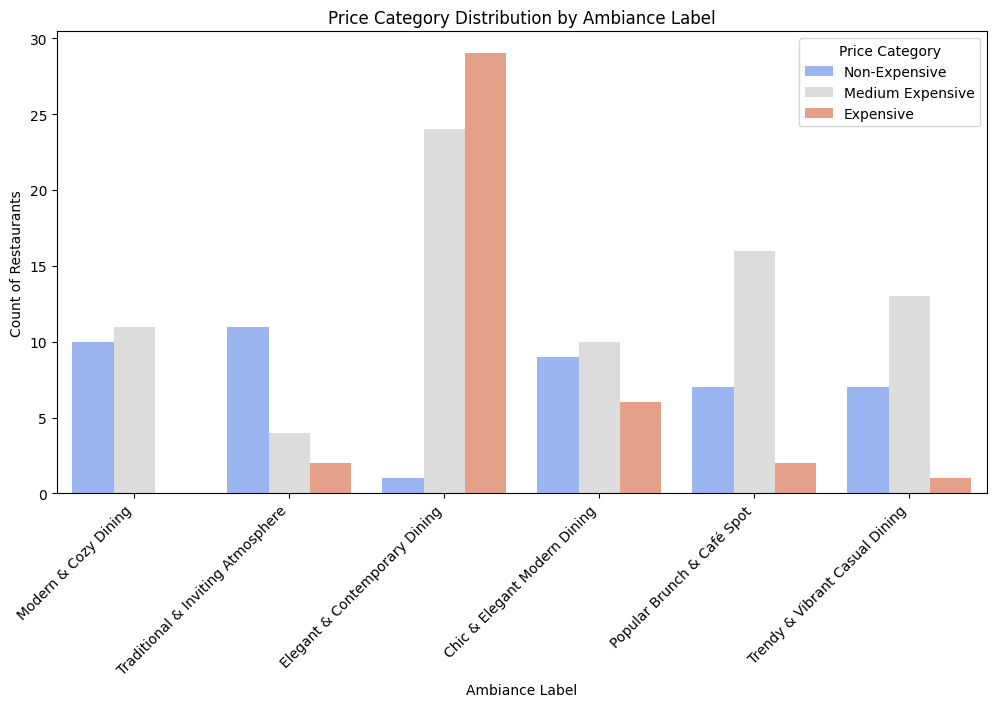

In [44]:
#Comparing the distribution of price categories across different ambiance categories/labels.
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Ambiance_Label', hue='Price_Category', palette='coolwarm')

plt.xticks(rotation=45, ha='right')
plt.xlabel("Ambiance Label")
plt.ylabel("Count of Restaurants")
plt.title("Price Category Distribution by Ambiance Label")
plt.legend(title="Price Category")
plt.show()

C:\Users\Game\AppData\Local\Temp\ipykernel_15684\3251328233.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Ambiance_Label', y='Rating_Value', palette='viridis')


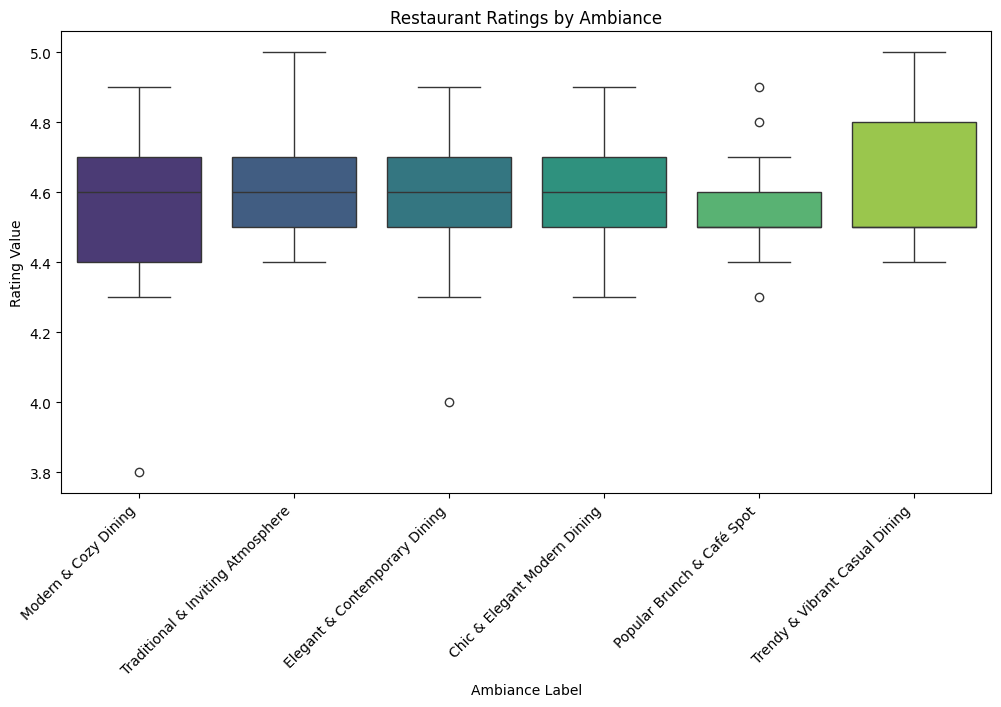

In [45]:
#Comparing the rating distribution across ambiance categories
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Ambiance_Label', y='Rating_Value', palette='viridis')

plt.xticks(rotation=45, ha='right')
plt.xlabel("Ambiance Label")
plt.ylabel("Rating Value")
plt.title("Restaurant Ratings by Ambiance")
plt.show()


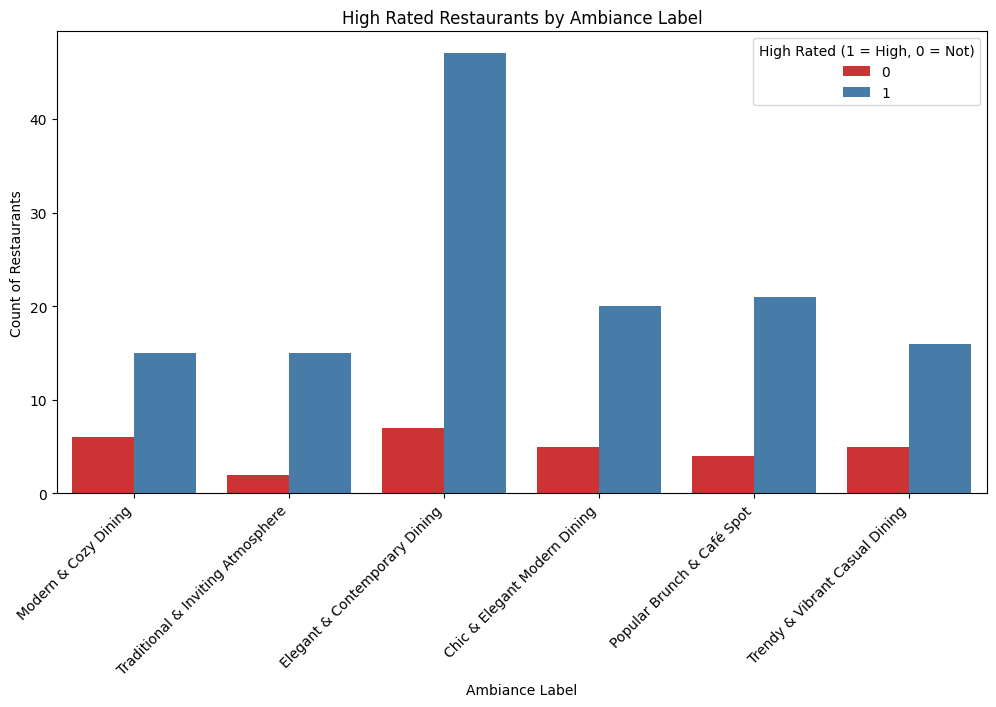

In [46]:
#proportion of high-rated restaurants in each ambiance category.
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Ambiance_Label', hue='High_Rated', palette='Set1')

plt.xticks(rotation=45, ha='right')
plt.xlabel("Ambiance Label")
plt.ylabel("Count of Restaurants")
plt.title("High Rated Restaurants by Ambiance Label")
plt.legend(title="High Rated (1 = High, 0 = Not)")
plt.show()

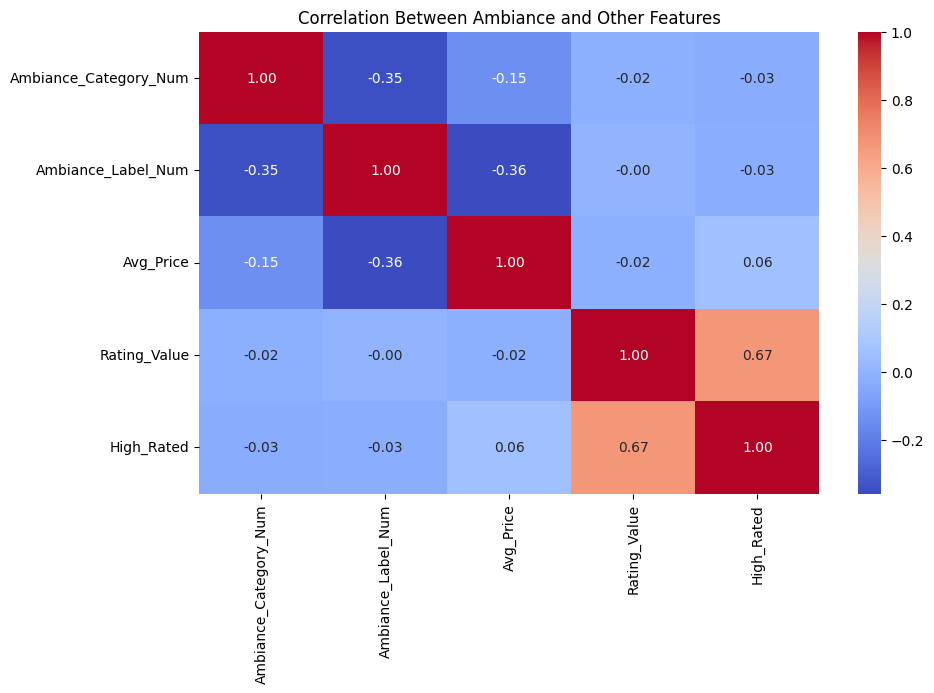

In [49]:
df['Ambiance_Category_Num'] = LabelEncoder().fit_transform(df['Ambiance_Category'])
df['Ambiance_Label_Num'] = LabelEncoder().fit_transform(df['Ambiance_Label'])

plt.figure(figsize=(10, 6))
sns.heatmap(df[['Ambiance_Category_Num', 'Ambiance_Label_Num', 'Avg_Price', 'Rating_Value', 'High_Rated']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f")

plt.title("Correlation Between Ambiance and Other Features")
plt.show()

C:\Users\Game\AppData\Local\Temp\ipykernel_15684\3317392584.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_reviews['Restaurant Name'], y=top_reviews['Review_Count'], palette="flare")


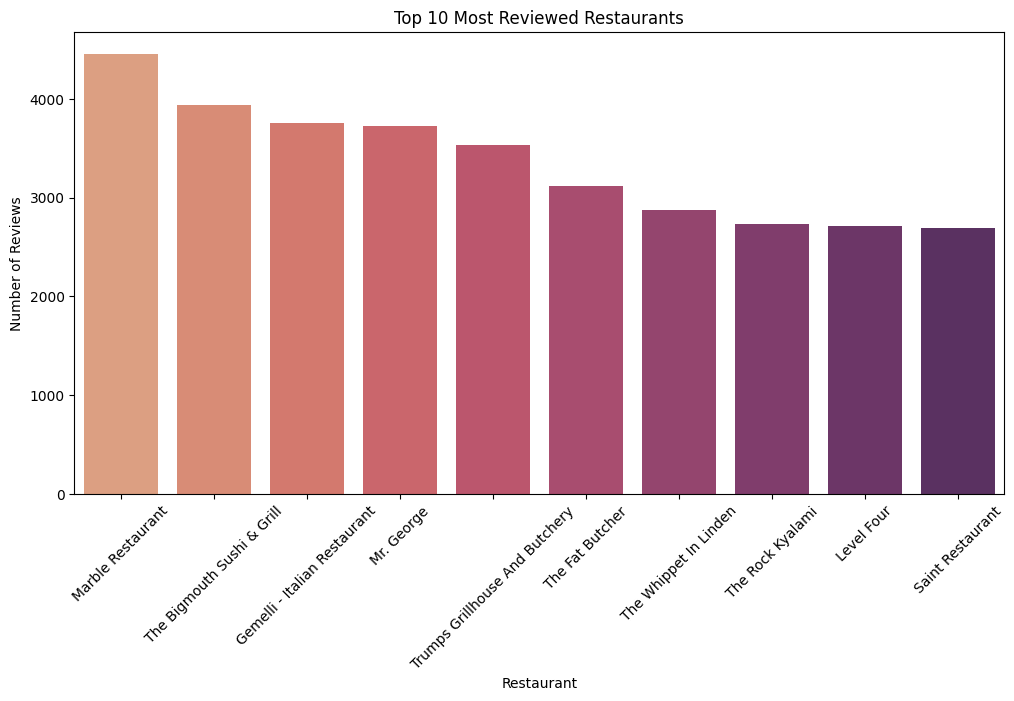

In [50]:
# Top 10 most reviewed restaurants
top_reviews = df[['Restaurant Name', 'Review_Count']].sort_values(by='Review_Count', ascending=False)[:10]
plt.figure(figsize=(12, 6))
sns.barplot(x=top_reviews['Restaurant Name'], y=top_reviews['Review_Count'], palette="flare")
plt.xticks(rotation=45)
plt.xlabel("Restaurant")
plt.ylabel("Number of Reviews")
plt.title("Top 10 Most Reviewed Restaurants")
plt.show()

C:\Users\Game\AppData\Local\Temp\ipykernel_15684\2073574317.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_reviews['Restaurant Name'], y=top_reviews['Rating_Value'], palette="flare")


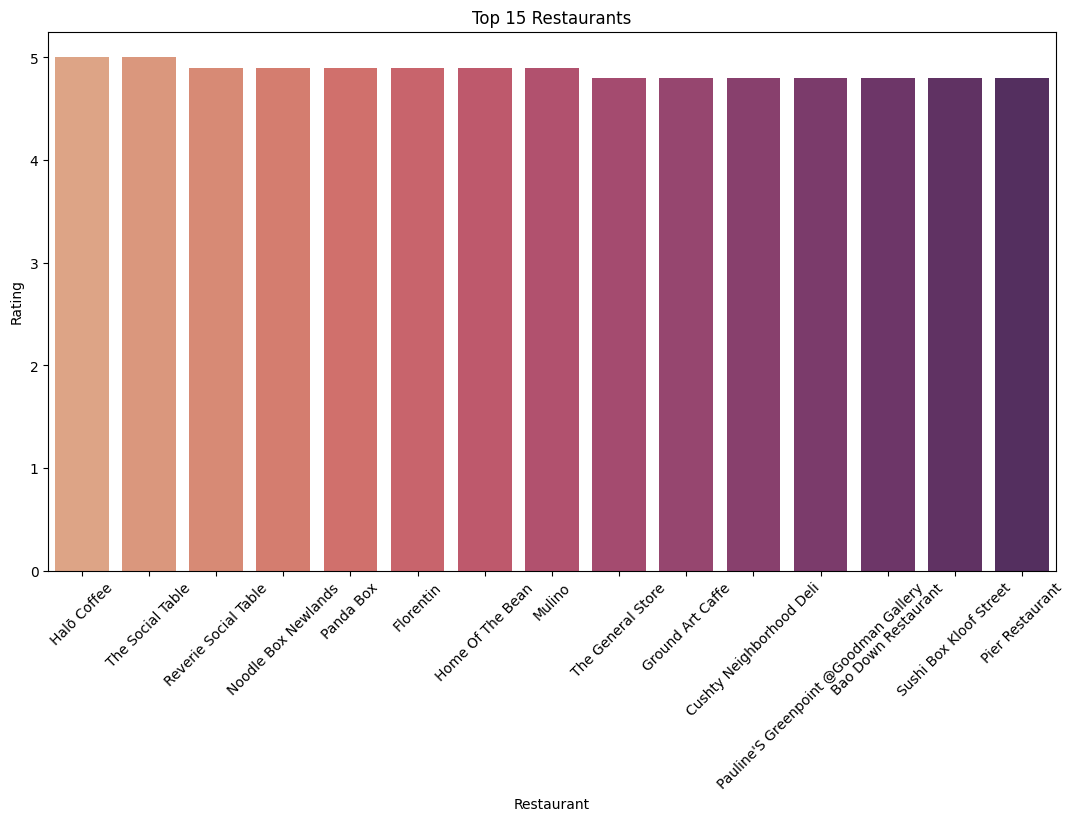

In [53]:
# Top 15 restaurants
top_reviews = df[['Restaurant Name', 'Rating_Value']].sort_values(by='Rating_Value', ascending=False)[:15]
plt.figure(figsize=(13, 7))
sns.barplot(x=top_reviews['Restaurant Name'], y=top_reviews['Rating_Value'], palette="flare")
plt.xticks(rotation=45)
plt.xlabel("Restaurant")
plt.ylabel("Rating")
plt.title("Top 15 Restaurants")
plt.show()

In [54]:
df.to_csv("restaurant data cleaned.csv")
print("CSV file saved successfully!")

CSV file saved successfully!


In [55]:
df.to_excel("restaurant data cleaned.xlsx")
print("Excel file saved successfully!")

Excel file saved successfully!
